<div>
<div>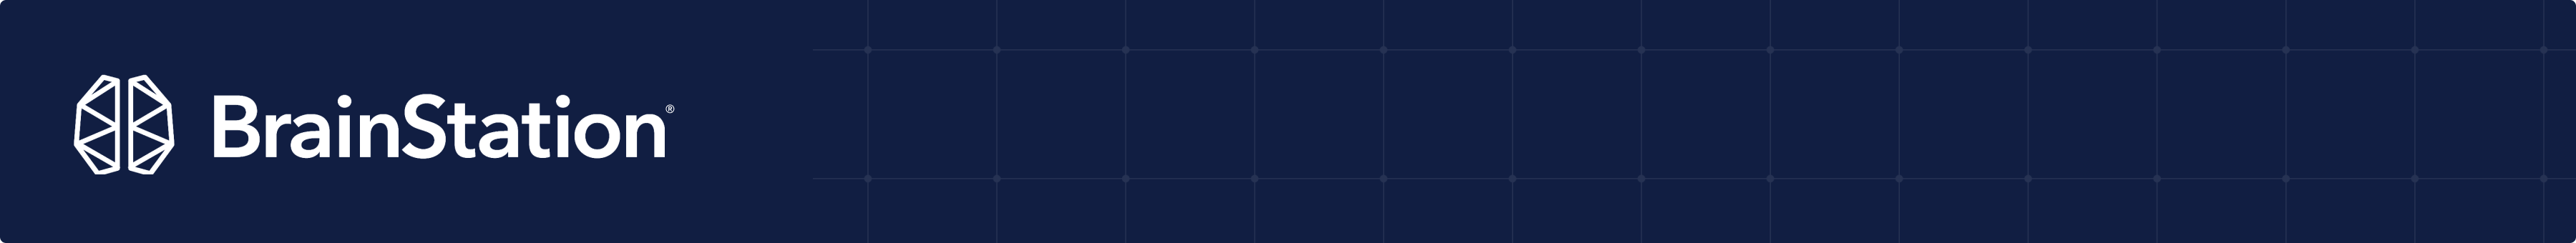


# Image Analysis

**Table of contents**<a id='toc0_'></a>    
- [Lesson Introduction  ](#toc1_)    
- [Setup  ](#toc2_)    
- [What Is Image Data?  ](#toc3_)    
  - [Gray Scale Images  ](#toc3_1_)    
  - [Color Images  ](#toc3_2_)    
  - [Examples  ](#toc3_3_)    
  - [Thresholding Images  ](#toc3_4_)    
- [Case Study: The MNIST Dataset  ](#toc4_)    
  - [Exploring the Dataset  ](#toc4_1_)    
  - [Flattening Images  ](#toc4_2_)    
- [Supervised Learning: Classifying Digits  ](#toc5_)    
  - [Exercise 1  ](#toc5_1_)    
- [Unsupervised Learning: Clustering Digits  ](#toc6_)    
  - [Reducing Image Dimensionality  ](#toc6_1_)    
  - [Exercise 2  ](#toc6_2_)    
- [Key Takeaways  ](#toc7_)    
- [Supplementary  ](#toc8_)    
  - [Optical Character Recognition  ](#toc8_1_)    
  - [Exercise 3  ](#toc8_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=3
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>Lesson Introduction   [&#8593;](#toc0_)

One famous quote says that a picture is worth a thousand words. Indeed, an image can contain more information than we are consciously aware of. There are numerous reasons why we might want to analyze data that comes in the form of images; some examples include facial detection, document sorting, cancer detection, as well as many others. As image analysis has become more popular, it has started being referred to as computer vision. So how can computers have vision?

This is exactly the topic covered in this lesson. We will look at how at the computer representation of images, what altering images actually does to them and how we can use that in analysis and modeling.

## <a id='toc2_'></a>Setup   [&#8593;](#toc0_)

First let's load all required libraries for this notebook.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from warnings import filterwarnings

# Loading sklearn functionality from prior lessons
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import fetch_openml

# Important functionality for this lesson
import pytesseract
from scipy.misc import face
import imageio

ModuleNotFoundError: No module named 'pytesseract'

Next, we'll define other settings we'll use throughought the notebook. 

In [2]:
# Setting globally figure size in the notebook
plt.rcParams["figure.figsize"] = (8.0, 6.0)

# Setting NumPy random seed
np.random.seed(42)

""" 
Suppressing warnings is generally not recommended. 
Warnings are being ignored in this notebook to prevent unnecessary clutter
and improve readability while working through the lesson
"""

filterwarnings(action='ignore')

## <a id='toc3_'></a>What Is Image Data?   [&#8593;](#toc0_)
Before we dive into data science image analysis techniques, let's get acquainted with this new type of data. Images can be stored in range of formats - jpg, bmp, or png to name a few. What exactly lies underneath these file formats, how exactly is the data stored? To answer that let's first look at gray scale data.

### <a id='toc3_1_'></a>Gray Scale Images   [&#8593;](#toc0_)
In the example below we are looking at an image of an eye. The image is quite large, so in order to demonstrate the underlying data representation we are zooming in on a small section of the image. When we zoom in we get a grid of pixels that have varying shades of black.

One way we could encode the different shades of black is using a number between 0 (black) and 255 (white). If we do that we get 2D array of pixel intensities as the diagram shows.

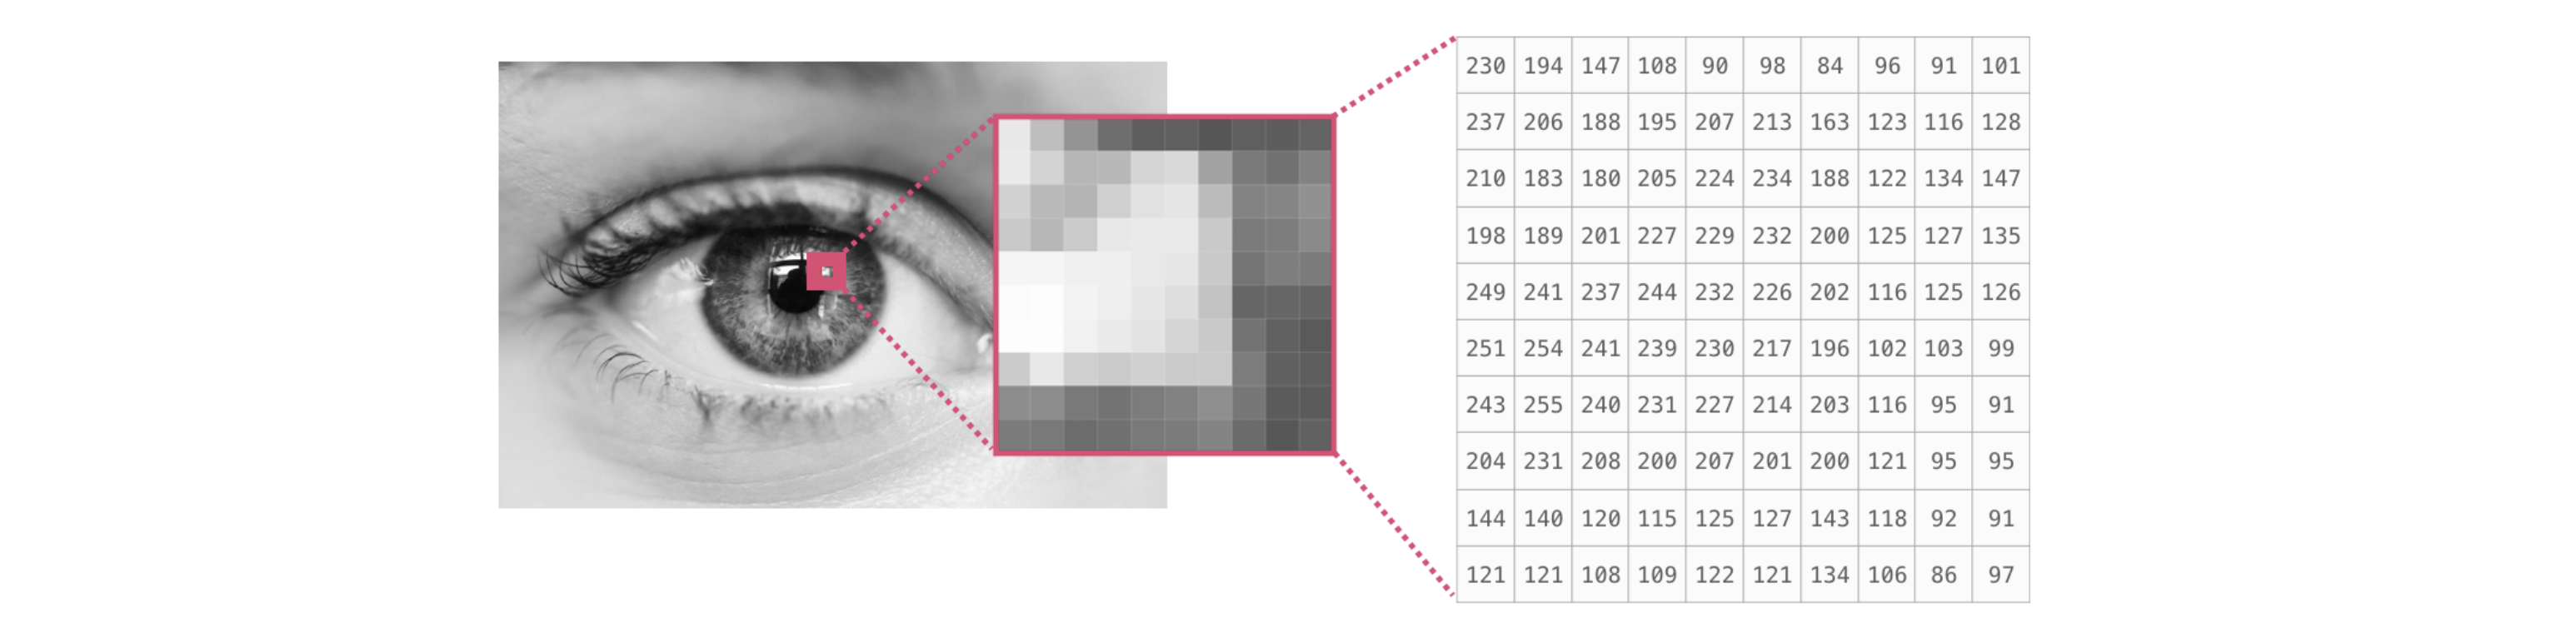 

[Image Source](https://jalammar.github.io/visual-numpy/)

### <a id='toc3_2_'></a>Color Images   [&#8593;](#toc0_)
What about color images, how is the data stored? 

It turns out that any color can be represented by "how much" red, green and blue it contains. We can express the idea of "how much" of each color as 3 numbers (one for each of red, green and blue). This means that we can represent an color image in the following way:

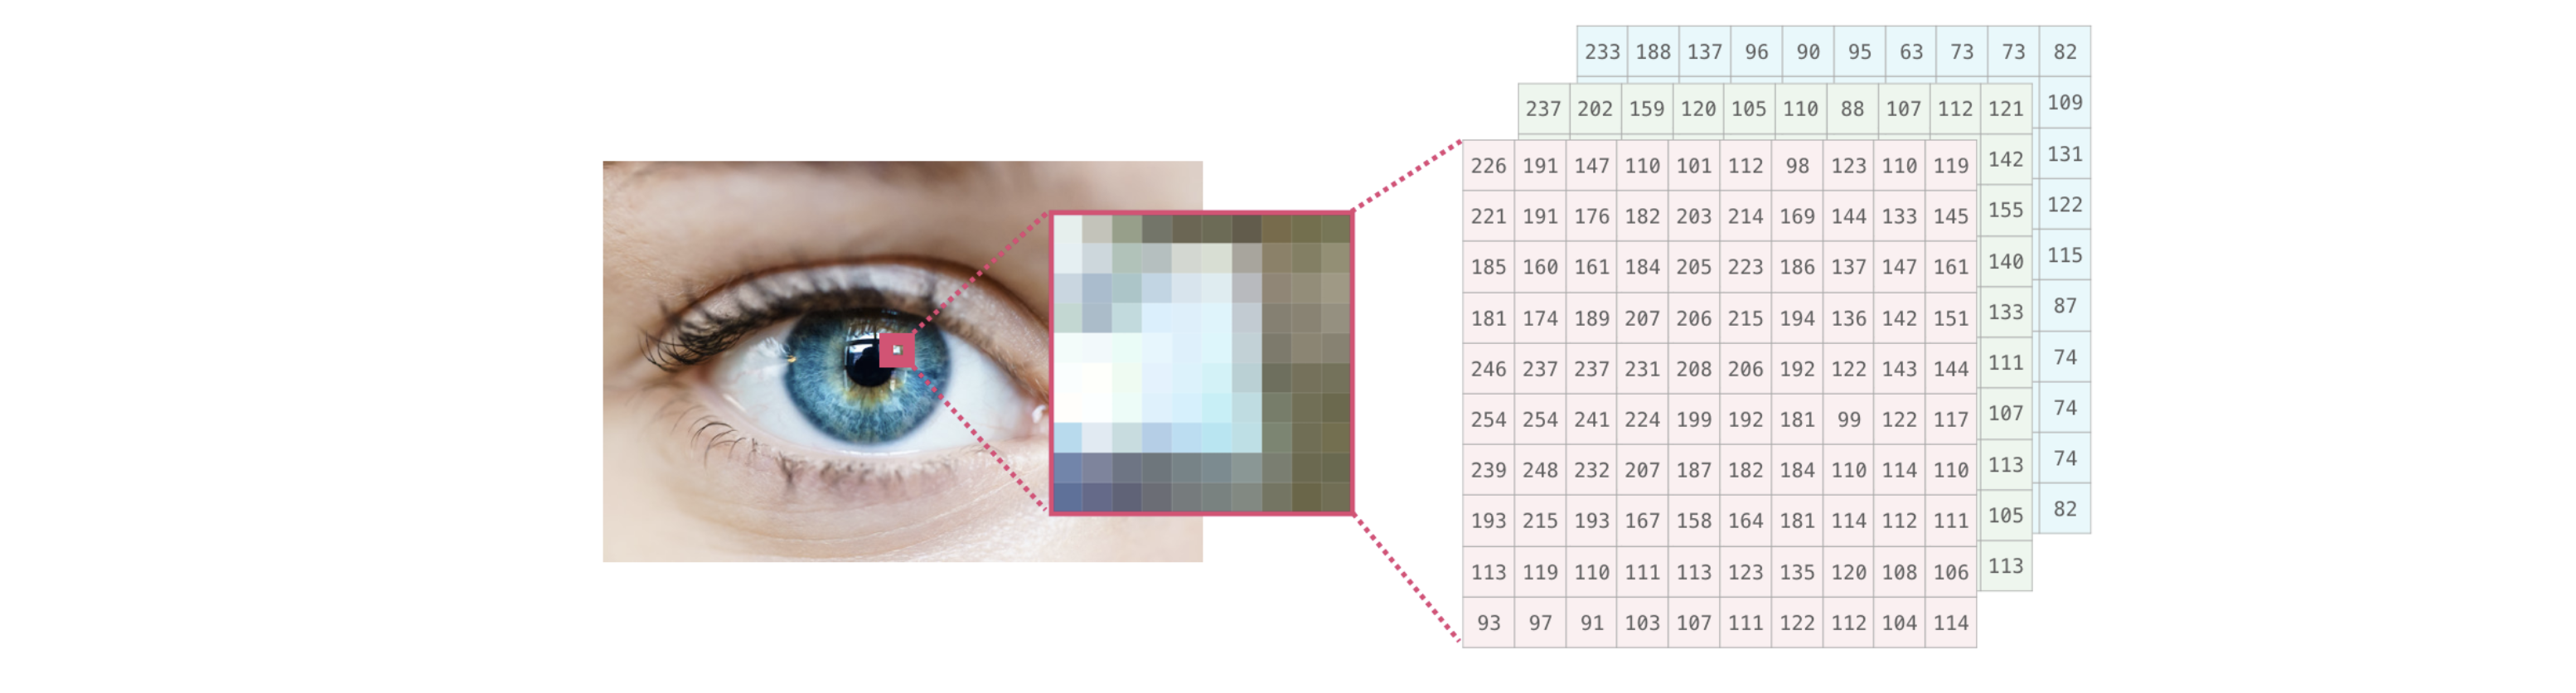

[Image Source](https://jalammar.github.io/visual-numpy/)

Each of the red, green and blue slices of numbers is the associated array of pixel intensities for that color. Taking all those slices together gives a 3-dimensional array that encodes the color of each pixel in the image. This is exactly how a color image is stored.

Putting what we've seen for color and gray scale images together, we have:

<div style="padding: 10px; border: 2px #000000 solid; background: #F6F6F4">

**<span style="color:#1358DB">What Is Image Data?</span>**

An image is an array of pixel intensity values. For gray scale images the array is 2-dimensional and the intensities encode shades of black. For color images the array is 3-dimensional and there is a slice for the intensities of each of the colors red, green and blue.

</div>

### <a id='toc3_3_'></a>Examples   [&#8593;](#toc0_)
Let's load some images and take a look at the underlying arrays of pixel intensities.

In [4]:
grayscale_raccoon = face(gray=True)
color_raccoon = face()

In [ ]:
print(f"The shape of the grayscale raccoon image is: {grayscale_raccoon.shape}")
plt.figure()
plt.imshow(grayscale_raccoon, cmap="gray")
plt.show()

In [ ]:
print(f"The shape of the color raccoon image is: {color_raccoon.shape}")
plt.figure()
plt.imshow(color_raccoon)
plt.show()

Inspecting each of the images, we see the gray scale image is a two dimensional NumPy array (height $\times$ width), and the color image is a three dimensional NumPy array (height $\times$ width $\times$ 3).

In [ ]:
print("The top 3 rows and columns in the image matrix")
grayscale_raccoon[:3, :3]

In [ ]:
print("The top 3 rows and columns in the image matrix in all channels")
color_raccoon[:3, :3, :]

We can see immediately how easily we can access the NumPy array that is underlying the image. Image pixels can also be represented in the range 0.0 - 1.0


In [ ]:
grayscale_raccoon_normalized = grayscale_raccoon / grayscale_raccoon.max()
grayscale_raccoon_normalized[:3, :3]

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(grayscale_raccoon_normalized, cmap="gray")
plt.show()

### <a id='toc3_4_'></a>Thresholding Images   [&#8593;](#toc0_)

Now that we know that images are interpretable as arrays, we can use NumPy methods to process them.

We usually want to work with images in one of three ways:

* Preprocess the image for a machine learning model
* Employ machine learning to predict unknown properties of images (*e.g.* facial recognition)
* Extract other information from images (*e.g.* extract text from written documents)


Let's try thresholding the raccoon image for better preprocessing later. First, let's look at thresholding on the gray scale image:

In [ ]:
raccoon_thresholded = np.where(grayscale_raccoon <= 128, 0, 255)
plt.figure()
plt.imshow(raccoon_thresholded, cmap="gray")
plt.show()

We can also use thresholding to try and remove certain elements. For example, let's remove the grass from the color raccoon image:

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(color_raccoon)
plt.show()

In [ ]:
# Define some magic numbers
RED = 0
GREEN = 1
BLUE = 2

# We start with making a placeholder for our new image
new_color_raccoon = np.zeros_like(color_raccoon)

# Assume we have grass wherever the green is larger than blue by some factor
grass_condition = color_raccoon[:, :, GREEN] > 1.05 * color_raccoon[:, :, BLUE]

# Now copy each channel, replacing the areas where 'grass_condition' is True to 0
for channel in [RED, GREEN, BLUE]:
    new_color_raccoon[:, :, channel] = np.where(grass_condition, 0, color_raccoon[:, :, channel])

plt.figure()
plt.imshow(new_color_raccoon)
plt.show()

## <a id='toc4_'></a>Case Study: The MNIST Dataset   [&#8593;](#toc0_)
We can also employ our machine learning techniques to do **image classification**. While the current state of the art is the application of deep learning, we can employ other methods with surprisingly good accuracy for many problems.

To demonstrate this we will be working with the modified digit dataset taken from the National Institute of Standards and Technology (MNIST). This dataset is composed of 70,000 hand written images and has become a canonical example of image classification in machine learning.

The dataset itself is a modified version of the NIST dataset which procured handwritten digits from the US Census Bureau and from US high school students. However, the data was originally set up such that the bureau digits were in the training set, and the digits written by high school students were in the test set. These two were later combined, shuffled, preprocessed to center all digits, and split again into 60,000 train images and 10,000 test images.

It has become somewhat of a contest to see who can get the best accuracy on the test set. [The state-of-the-art (SOTA) results are currently around 99.9% accuracy.](https://en.wikipedia.org/wiki/MNIST_database#Performance)

In [14]:
# This will take some time, about a minute
DATA_PATH = "data/mnist"
mnist = fetch_openml("mnist_784", data_home=DATA_PATH, as_frame=False)

In [15]:
# The dataset comes pre-flattened, we will see what that means in a second but
# we have to reshape it to display as images

images = mnist.data.reshape(-1, 28, 28)
classes = mnist.target.astype(np.int32)

In [ ]:
print(f"The shape of the dataset is {images.shape}")

### <a id='toc4_1_'></a>Exploring the Dataset   [&#8593;](#toc0_)
Let's take a look at one of the images:

In [ ]:
plt.figure()
plt.imshow(images[0], cmap="gray_r")
plt.title("Example Image From MNIST")
plt.show()

In [ ]:
print(f"The shape of the first image is {images[0].shape}")

We can see each image is sized 28x28 and in monochrome (black-and-white). We can also look at a representative image from each class:

In [ ]:
plt.subplots(2, 5, figsize=(10, 5))

for target in range(0, 10):
    plt.subplot(2, 5, target + 1)
    plt.imshow(images[classes == target][0], cmap="gray_r")
    plt.title(f"Example of {target}")

plt.tight_layout()
plt.show()

We can also get an idea of how varied the images are by looking at image averages. Some digits might be written similarly by many people, while others might have a lot of variation:

In [ ]:
plt.subplots(2, 5, figsize=(10, 5))

for target in range(0, 10):
    plt.subplot(2, 5, target + 1)
    plt.imshow(np.mean(images[classes == target], axis=0), cmap="gray_r")
    plt.title(f"Mean of {target}")

plt.tight_layout()
plt.show()

0 seems to be pretty uniform across the dataset, which is why it has no fuzzy areas. The digit 1, on the other hand, seems to be written as either slanted right or left. This is why only the middle section is consistent while the tips show an almost equal distribution of being slanted right or left. 

You can also see there are blurry areas for the digits 4, 7, and 9 as well. This shows there is variation in how they are drawn. For example, some people will draw a 7 with the 'hook' on the end whereas others do not.

### <a id='toc4_2_'></a>Flattening Images   [&#8593;](#toc0_)

There are a few ways we can employ this dataset to showcase ML techniques on image data. But first, how do we go from images to the data our ML models are used to? We cannot train a model in sklearn on $28\times28$ arrays so how should we proceed?

The answer is we **flatten** the image! If we have an image which is $3\times3$ as follows:

In [ ]:
random_image = np.random.random(9).reshape(3, 3)

plt.figure(figsize=(3, 3))
plt.imshow(random_image)
plt.title("Original 3X3 Image")
plt.show()

print(f"Our original image shape is: {random_image.shape}")

We can flatten it into the following $1\times9$ vector of pixels values:

In [ ]:
flat_image = random_image.reshape(1, random_image.shape[0] * random_image.shape[1])

plt.figure(figsize=(9, 1))
plt.imshow(flat_image)
plt.title("Flattened Image: Now 1x9")
plt.show()

print(f"Our flat image shape is: {flat_image.shape}")

Doing the same for one of our MNIST images, we can take the following:

In [ ]:
first_image = images[0]

plt.figure(figsize=(3, 3))
plt.imshow(first_image, cmap="gray_r")
plt.title("Example MNIST Image")
plt.show()

print(f"Our original image shape is: {first_image.shape}")

And flatten it as follows:

In [ ]:
flat_image = first_image.reshape(1, 28 * 28)  # Every image is 28 by 28 in this dataset
print(f"Our flat image shape is: {flat_image.shape}")

In fact, we can flatten the entire dataset:

In [ ]:
flattened_dataset = images.reshape(images.shape[0], 28 * 28)  # Keep the same number of data points

print(f"Our original dataset shape is: {images.shape}")
print(f"Our flat dataset shape is: {flattened_dataset.shape}")

## <a id='toc5_'></a>Supervised Learning: Classifying Digits   [&#8593;](#toc0_)
Now that we have flattened each image in the dataset we have a 2D array. There are 70,000 rows each of which representing one image. There are 784 columns which are the pixel intensity values (but remember we are now dealing with the flattened version of each image).

We also have class labels for each of the images (0, 1, 2...9) which will be our target variable. Now we can proceed to apply supervised techniques as we would for any other problem. We will do this in the exercise below.

### <a id='toc5_1_'></a>Exercise 1   [&#8593;](#toc0_)

1. Run a logistic regression on the dataset below. Set the solver to `saga`, the penalty to `l1`, the C value to `10`, and maximum iterations to `20`. What is the performance of your model?
2. Use the regression coefficients to plot the importance of individual pixels, can you plot these as a $28 \times 28$ image?

In [26]:
# Flattening the image and splitting it into train and test
X = flattened_dataset
y = mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## <a id='toc6_'></a>Unsupervised Learning: Clustering Digits   [&#8593;](#toc0_)

By reshaping the data, we were able to apply supervised learning to do image classification. But what if we did not have a labeled dataset? We can also employ unsupervised learning approaches on our images to find clusters of similar images.

Let's use k-means clustering to see if we can pull out similar images in the MNIST dataset, and if these clusters will line up with the class labels. Are the similarities between how different people draw a given digit enough to naturally group them together, or are there stronger similarities between how different individuals draw different digits?

In [ ]:
# Exploring the first 9 images in the dataset

images = mnist.data.reshape(-1, 28, 28)  # The dataset comes pre-flattened, reshaping it to display as images
classes = mnist.target.astype(np.int32)

plt.subplots(3, 3, figsize=(7, 7))
for counter in range(9):
    plt.subplot(3, 3, counter + 1)
    plt.imshow(images[counter], cmap="gray_r")
    plt.title(f"Class {classes[counter]}")

plt.suptitle("First Nine Images in the MNIST Dataset")
plt.tight_layout()
plt.show()

But how will K-Means work on this data? Consider two random examples of the digit 2:

In [38]:
# Getting all number 2s from the dataset
all_twos = images[classes == 2]

In [ ]:
first_image = all_twos[0]
second_image = all_twos[1]

# Showing the first example of digit 2
plt.figure()
plt.imshow(first_image, cmap="gray_r")
plt.title("First Example of 2")
plt.show()

# Showing the second example of digit 2
plt.figure()
plt.imshow(second_image, cmap="gray_r")
plt.title("Second Example of 2")
plt.show()

To test for the distance between data points for K-Means, recall we take the Euclidean distance between points. That is, for all of the $D$ features we take:

$$distance(\vec{b}, \vec{a}) = \sqrt{\sum_{i=0}^D (b_i - a_i)^2}$$

For tabular data this means subtracting the different features such as price, or height, or length.

However, for images, this means subtracting the pixel intensity values. To look at the distance between the two images:
* We subtract the pixel intensities of one image from the other
* Square the result
* Finally, take the square root of the sum

In [ ]:
# Subtract the images from each other
difference_image = first_image - second_image

# Square and visualize
squared_image = difference_image**2
plt.figure()
plt.imshow(squared_image, cmap="gray_r")
plt.title("Visualizing the Difference")
plt.show()

# Take the square root of the sum
distance = np.sqrt(np.sum(squared_image))
print(f"Distance is {distance.round(2)}")

In the above image, white areas are areas where the images have identical values, while black areas are those where the two images are mostly different.

Let's sample a fraction of the dataset, and run K-Means on that resulting subsample. Here we will choose K=10, hoping that the unsupervised method will find the class labels we already know exist:

In [41]:
dataset_size = images.shape[0]
subsample_fraction = 0.5
subsample_size = int(dataset_size * subsample_fraction)

subsample_images = mnist.data[:subsample_size]  # Grab the first 50% of images, they should be representative

In [42]:
# This would run for some time
my_Kmeans = KMeans(n_clusters=10, random_state=1)
my_labels = my_Kmeans.fit_predict(subsample_images)

The runtime is a bit of a problem, we are only working with a subset and this is still computationally intensive. We need to find a way to reduce the runtime if we want to run this algorithm for the entire dataset.

### <a id='toc6_1_'></a>Reducing Image Dimensionality   [&#8593;](#toc0_)

While the methodology outlined above can work, notice the majority of the squared image is white. That is, most pixels don't really have any difference because the image is centered.

From a computational standpoint, this means we are spending most of our time looking at all the pixels that are the same in all images. That is to say, most of the _variability_ in different images is actual limited to a smaller number of particular pixels which differentiate one digit from another.  We can get around this by employing PCA to reduce the dimensionality of the images.

This will greatly reduce the computation time for K-means, given that we are reducing the number of features and therefore dimensions, to compute distances across.

### <a id='toc6_2_'></a>Exercise 2   [&#8593;](#toc0_)

1. Reduce the dimensionality of the data using PCA such that 90% of the variance remains, what is the shape of the reduced dataset?
2. Use the reduced dataset and KMeans clustering to find 10 clusters in the data. How do you expect the data to cluster?
3. Plot the means of each cluster as images, what does each cluster represent?

In [ ]:
# Flatten the image dataset again
flattened_dataset = images.reshape(images.shape[0], 28 * 28)  # Keep the same number of data points

print(f"Our original dataset shape is: {images.shape}")
print(f"Our flat dataset shape is: {flattened_dataset.shape}")

## <a id='toc7_'></a>Key Takeaways   [&#8593;](#toc0_)
- An image is an array of pixel intensity values. 
    - For gray scale images the array is 2-dimensional and the intensities encode shades of black. 
    - For color images the array is 3-dimensional and there is a slice for the intensities of each of the colors red, green and blue.


- We can apply preprocessing techniques to normalize or threshold images to put greater or lesser emphasis on different areas.

- To prepare images for machine learning models, we need to "flatten" them using `reshape()`.

- Once an image dataset has been flattened we can apply supervised and unsupervised techniques using `scikit-learn` as usual.

-------

## <a id='toc8_'></a>Supplementary   [&#8593;](#toc0_)
The following supplementary section covers another image analysis use case.



### <a id='toc8_1_'></a>Optical Character Recognition   [&#8593;](#toc0_)
Sometimes we want to extract information from a document. For these cases, we use an Optical Character Recognition (OCR) program. A good example is the dirty documents dataset from UCI, where there are have many images of documents with creases and spills on them. You can download the dataset from **Synapse**.


The reference for this dataset is: 

*Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science*

Let's open some as examples:

In [ ]:
crease_image = imageio.imread("data/train/5.png")
plt.figure(figsize=(13, 13))
plt.imshow(crease_image, cmap="gray")
plt.show()

Let's use [Tesseract](https://github.com/tesseract-ocr/), an Optical Character Recognition (OCR) library, to read the text in this image and convert it into a string. More specifically we will use Pytesseract which is a Python 'wrapper' library that allows us to interact with Tesseract using Python.

**Note: To use these packages, you should start Jupyter after activating the new environment we installed. Tesseract does not work when using the 'Change Kernel' feature.**

In [ ]:
text_string = pytesseract.image_to_string(crease_image)
print(text_string)

Let's try a more complex example.

In [ ]:
coffee_image = imageio.imread("data/train/2.png")

plt.figure(figsize=(13, 13))
plt.imshow(coffee_image, cmap="gray")
plt.show()

text_string = pytesseract.image_to_string(coffee_image)
print(text_string)

This time, although the overall performance isn't terrible, there are some words that were completely misread. Let's try and help our OCR by performing some thresholding.

In [ ]:
threshold = 90
image_thresh = np.where(coffee_image <= threshold, 0, coffee_image)
image_thresh = image_thresh.astype(np.uint8)

plt.figure(figsize=(13, 13))
plt.imshow(image_thresh, cmap="gray")
plt.show()

In [ ]:
text_string = pytesseract.image_to_string(image_thresh)
print(text_string)

The performance has improved. Let's try and improve it even further by using clustering:

In [ ]:
# Create a dataset of [x-coord, y-coord, pixel-value] triplets
data = []
for x_coord in range(image_thresh.shape[1]):
    for y_coor in range(image_thresh.shape[0]):
        data.append([x_coord, y_coor, image_thresh[y_coor][x_coord]])

In [ ]:
# Scale the data
data_scaled = StandardScaler().fit_transform(np.array(data))

In [ ]:
# We're expecting about 8 clusters: 6 coffee stains, plus text, plus background
my_GMM = GaussianMixture(n_components=8, random_state=1)
predictions = my_GMM.fit_predict(data_scaled)

In [ ]:
# Create a new version of the image with cluster labels as pixel values
image_new = np.zeros_like(image_thresh)

counter = 0
for x_coor in range(image_thresh.shape[1]):
    for y_coor in range(image_thresh.shape[0]):
        image_new[y_coor][x_coor] = predictions[counter]
        counter += 1

In [ ]:
plt.figure(figsize=(13, 13))
plt.imshow(image_new, cmap="gray")
plt.show()

In [ ]:
# If you explore the different clusters you will find cluster 5 contains our text
text_cluster_image = np.where(image_new == 5, 0, 255)

plt.figure(figsize=(13, 13))
plt.imshow(text_cluster_image, cmap="gray")
plt.show()

In [ ]:
augmented_image = text_cluster_image + coffee_image
augmented_image = 255 * augmented_image / augmented_image.max()
augmented_image = augmented_image.astype(np.uint8)

plt.figure(figsize=(13, 13))
plt.imshow(augmented_image, cmap="gray")
plt.show()

In [ ]:
text_string = pytesseract.image_to_string(augmented_image)
print(text_string)

There might be some more automation we can employ to augment the image, but this illustrates the general idea of employing the techniques we have learned to augment our image analysis capabilities.

---
### <a id='toc8_2_'></a>Exercise 3   [&#8593;](#toc0_)

1. Make a DBSCAN model to find clusters in the 2.png image. How well does it perform?
---

<div id="container" style="position:relative;">
<div style="position:relative; float:right">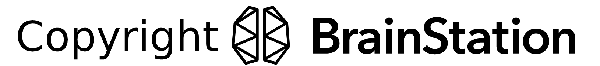
</div>
</div>
